In [9]:
from control_guided_nas import get_max_diam
from itertools import product
import pandas as pd
import numpy as np
import concurrent.futures
from tqdm import tqdm

systems = ["F1", "CC"]
latency = np.arange(0.005, 1, 0.005)
accuracy = np.arange(0.5, 1.0, 0.02)

rows = []

with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    futures_to_args = {}
    for argset in product(systems, latency, accuracy):
        s, l, a = argset
        futures_to_args[executor.submit(get_max_diam, l, 1 - a, s)] = argset
    
    with tqdm(total=len(futures_to_args)) as pbar:
        for future in concurrent.futures.as_completed(futures_to_args):
            try:
                diameter = future.result()
                rows.append([*futures_to_args[future], diameter])
                pbar.update(1)
            except AttributeError as e:
                print(futures_to_args[future])

# for sys in systems:
#     for l in latency:
#         for a in accuracy:
#             rows.append([l, a, sys, diam(l, a, sys)[1]])

df = pd.DataFrame(rows, columns=["system", "latency", "accuracy", "diameter"])
df

# Plotting
# for sys in ["F1", "CC"]:
#     for setup in ["l11_tcp", "l15_tcp", "l11_udp", "l15_udp"]:
#         plt.plot(range(1, 6), diameter[sys][setup], label=f"{sys} {setup}", marker="o", lw=4, markersize=15)
#     plt.xticks(range(1, 6), fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.xlabel("Network loss (%)", fontsize=20)
#     plt.ylabel("Max diameter of reachable sets (m)", fontsize=20)
#     # plt.title("Reachability analysis with a simplified cruise control model", fontsize=18)
#     plt.legend(fontsize=15)
#     plt.show()

100%|██████████| 9950/9950 [00:16<00:00, 616.20it/s] 


,system,latency,accuracy,diameter
0,F1,0.005,0.52,10.736149
1,F1,0.005,0.54,7.995362
2,F1,0.005,0.60,3.301807
3,F1,0.005,0.50,14.420136
4,F1,0.005,0.64,2.649038
...,...,...,...,...
9945,CC,0.995,0.90,6.203268
9946,CC,0.995,0.92,6.150615
9947,CC,0.995,0.94,6.098060
9948,CC,0.995,0.96,6.045602


In [12]:
df.to_csv("diameters_v2.csv", index=False)

In [16]:
df = pd.read_csv("diameters_v2.csv")

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

def plot_scan(df: pd.DataFrame, sysname: str):
    data = df[df['system'] == sysname]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    latency_vals = data['latency'].values
    accuracy_vals = data['accuracy'].values
    diameter_vals = data['diameter'].values
    minima = np.argmin(diameter_vals)

    surf = ax.plot_trisurf(latency_vals, accuracy_vals, diameter_vals, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.scatter(latency_vals[minima], accuracy_vals[minima], diameter_vals[minima], s=100, marker='o', color='red')

    ax.set_xlabel('Latency')
    ax.set_ylabel('Accuracy')
    ax.set_zlabel('Diameter')

    # def update(frame):
    #     ax.view_init(elev=30, azim=frame)
    #     return fig,

    # ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 5), interval=100, blit=True)
    # ani.save(f'{sysname}.gif', writer=PillowWriter(fps=10))

    ax.view_init(elev=30, azim=120)
    plt.show()

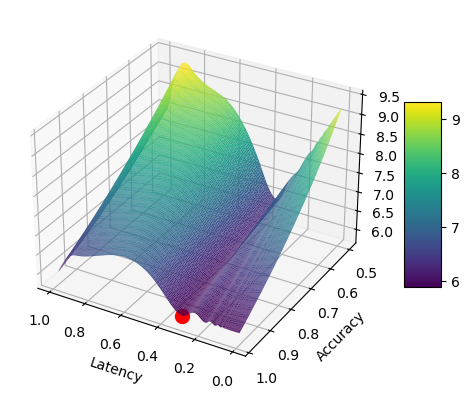

In [18]:
plot_scan(df, "CC")

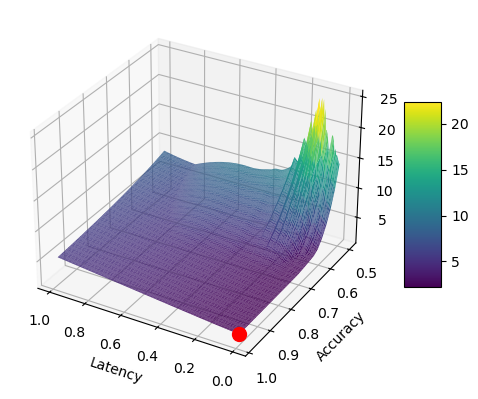

In [19]:
plot_scan(df, "F1")